<a href="https://colab.research.google.com/github/aleduenas/VIM-Reinforcement-Learning-Agent/blob/main/nim_agent_with_graphics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from google.colab.patches import cv2_imshow

In [ ]:
# RL parameters
# number of episodes
num_episodes = 20000
# discount past
gamma = 0.99
# learning rate
alpha = 0.2
# nim game size
## Use this line to change the
## number of tokens to play the game with
nim_size = 16
# state-action pair table for the agent
nim_agent = np.zeros([nim_size, 3])
# list to store game results
game_results = []

In [ ]:
# parameters for visualization

# agent's token will turn green
agent_color = (0, 255, 0)
# machine's token will turn orange
machine_color = (0, 165, 255)
# untaken token
untaken_color = (255, 255, 255)
# how often to see the updates
show_interval = 1000
# window for rolling average
window = 500
# text template to update every interval
template = "Episode:{}\nLast {} game win rate: {:.3f}"
# graphic window size
SIZE = 100
# graphical placement of tokens
token_x = [int(x) for x in np.linspace(0, SIZE, nim_size + 2)[1:-1]]
token_top = int(np.floor(SIZE * 0.4))
token_bot = int(np.floor(SIZE * 0.8))
token_head = token_top - 1
# time to display
turn_time = 50
results_time = 100

# legend
# font
font = cv2.FONT_HERSHEY_SIMPLEX
fontScale = 1
# coordinates for text
org = [(token_x[0], 100), (token_x[0], 150)]
#thickness
thickness = 1
text = ["Agent Color", "Machine Color"]

# matches left
score = "{}"
org_game = (450, 150)

def display_game(token_order, tokens,user,machine,training, reward):
    env = np.zeros((SIZE, SIZE, 3), dtype=np.uint8)
    # displaying tokens
    for token in range(nim_size):
        # if token has been taken yet
        if token < len(token_order):
            # player took it
            if token_order[token]:
                color = agent_color
            # agent took it
            else:
                color = machine_color
        else:
            color = untaken_color
        env[token_top:token_bot, token_x[token]] = color
        env[token_head, token_x[token]] = (0, 0, 255)
    img = Image.fromarray(env, "RGB")
    img = np.array(img.resize((600, 600)))
    img = cv2.putText(
        img, user, org[0], font, fontScale, agent_color, thickness, cv2.LINE_AA
    )
    img = cv2.putText(
        img, machine, org[1], font, fontScale, machine_color, thickness, cv2.LINE_AA
    )
    img = cv2.putText(
        img, score.format(tokens), org_game, font, 3, untaken_color, 3, cv2.LINE_AA
    )
    cv2_imshow(np.array(img))
    if training & reward != 0:
        cv2.waitKey(results_time)

    else:
        cv2.waitKey(turn_time)



In [ ]:
# RL
# TD Q-learning
for episode in range(num_episodes):
    if (episode + 1) % show_interval == 0:
        print(
            template.format(
                episode + 1, window, np.mean(game_results[episode - window : episode])
            )
        )
        print(nim_agent)
        show = True
    else:
        show = False
    # keeping track of who took which tokens
    token_order = []
    # initialize new game
    game_tokens = nim_size
    # determine starting player
    starting_player = np.random.randint(2)
    # reset the reward
    reward = 0
    # take random opponent action
    if not starting_player:
        random_action = np.random.randint(1, 4)
        game_tokens -= random_action
        # keeping track of machine actions for visualization
        token_order += [0 for x in range(random_action)]
    # game_tokens - 1 since python indexing starts at 0
    next_state = game_tokens - 1
    # game continues until no more tokens
    while game_tokens > 0:
        # next time step
        state = next_state
        # exploit or explore probability
        prob_exploit = 1 - 0.5 * np.exp(-0.0005 * episode)
        # exploit
        if np.random.random() < prob_exploit:
            # select the best state action pair with the highest value
            action = np.argmax(nim_agent[state])
        # explore
        # take a random action
        else:
            action = np.random.randint(0, 3)

        # update the game after agent's action
        # add 1 to the action since the action is in [0, 2] because of python
        game_tokens = max(game_tokens - (action + 1), 0)
        # keeping track of agents tokens for visualization
        token_order += [1 for x in range(action + 1)]

        # check if agent took last token
        if game_tokens < 1:
            # losing is -1 reward
            reward = -1
        # random opponent action
        # this counts as part of the unobserved environment, the next state for
        # the agent is going to always include the opponents action i.e. the opp
        # action is just how the environment reacts to the agents action
        random_action = np.random.randint(1, 4)
        game_tokens = max(game_tokens-random_action,0)
        # keeping track of machine actions for visualization
        token_order += [0 for x in range(random_action)]

        # check to see if agent wins (opp loses)
        if game_tokens < 1 and reward == 0:
            game_tokens = 0
            reward = 1

        if show:
            display_game(token_order, game_tokens,text[0],text[1],1,reward)
        # old value
        current_q = nim_agent[state, action]
        # trigger the end of the game if the last token was pulled
        if reward != 0:
            nim_agent[state, action] = reward
            break
        else:
            # get the next state for q-learning purposes
            next_state = game_tokens - 1
            # best action for the next state to get s', a'
            next_action = np.argmax(nim_agent[next_state])
            future_q = nim_agent[next_state, next_action]
            # old value
            current_q = nim_agent[state, action]

            # update q-table
            # reward will be 0 unless agent wins or loses
            # the q table will be updated based on how close we are to a winning position however
            # with the end rewards being propagated back as favorable states
            # this helps the agent learn quickly mid episodes despite the sparse
            # reward schedule
            nim_agent[state, action] = (1 - alpha) * current_q + alpha * (
                reward + gamma * future_q
            )
    # track game results either 1 for a win or 0 for a loss
    game_results.append(max(reward, 0))

cv2.destroyAllWindows()

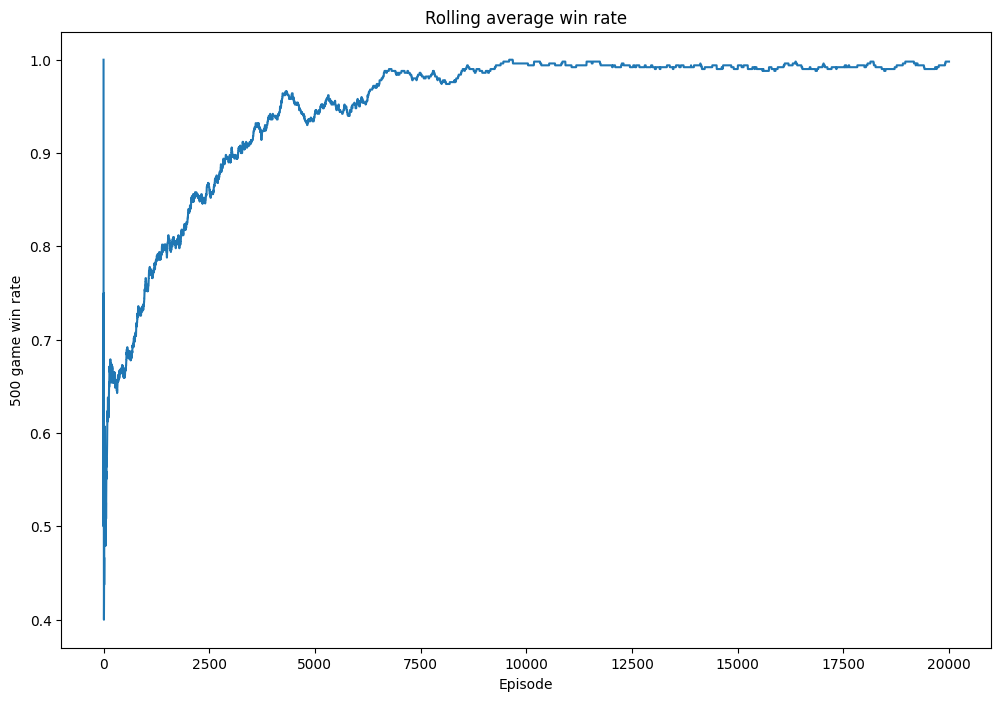

In [ ]:
# rolling average 200 game window
rolling_avg_win_rate = [
    np.mean(game_results[n - window : n]) if n > window else np.mean(game_results[:n])
    for n in range(1, len(game_results))
]


# Plot results
plt.figure(figsize=(12, 8))
plt.plot(rolling_avg_win_rate)
plt.title("Rolling average win rate")
plt.xlabel("Episode")
plt.ylabel(f"{window} game win rate")
# plt.savefig('Agent Total Return Linear.png')
plt.show()


In [ ]:
##playable game with the bot

# Get user input for their turn
def user_turn():
    while True:
        try:
            tokens = int(input("Remove tokens (1-3):"))
            if tokens < 1 or tokens > 3:
                raise ValueError
            break
        except ValueError:
            print("Invalid integer. The number must be in the range of 1-3")
    user_action = tokens
    return user_action

# Game logic
def user_game():
    token_order = []
    tokens = nim_size
    # randomly determine who starts
    starting_player = np.random.randint(2)
    game_over = 0
    display_game(token_order, tokens,"Your color",text[0],0,1)
    if starting_player:
        # take input from defined function as your move
        user_action = user_turn()
        tokens -= user_action
        # keeps record of which tokens were taken by whom
        token_order += [1 for x in range(user_action)]
        # displays the new state of the game
        display_game(token_order, tokens,"Your color",text[0],0,1)

    while tokens > 0: # Game hasn't ended yet
        # Defining the state for the agent to see
        state = tokens - 1
        # Choosing the best action for the current state
        bot_action = np.argmax(nim_agent[state]) + 1
        tokens -= bot_action
        # check to see if agent took last match
        if tokens < 1:
            tokens = 0
        #adds the matches the agent took out to the records
        token_order += [0 for x in range(bot_action)]
        print("Bot move", bot_action)
        display_game(token_order, tokens,"Your color",text[0],0,1)
        if tokens < 1:
            print("you win")
            break
        else:
            user_action = user_turn()
            tokens -= user_action
            token_order += [1 for x in range(user_action)]
            display_game(token_order, tokens,"Your color",text[0],0,1)
            if tokens < 1:
                print("you lose")
                break



In [ ]:
# loop to start and continue game until user stops
buko = 1
while buko:
    user_game()